from ultralytics import YOLO

In [1]:
from ultralytics import YOLO


In [2]:
model = YOLO("yolov8s-seg.pt")

100%|██████████| 22.8M/22.8M [00:01<00:00, 13.2MB/s]
c:\Users\anirv\OneDrive\Desktop\sem 5\Intro to Machine Learning\Project\.venv\Lib\site-packages\ultralytics\nn\tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for 

In [30]:
# Segment the image
results = model("canva 1.png")

# Extract segmentation details
masks = results[0].masks.data.cpu().numpy()  # Binary masks (one per object)
boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes: [x_min, y_min, x_max, y_max]


TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


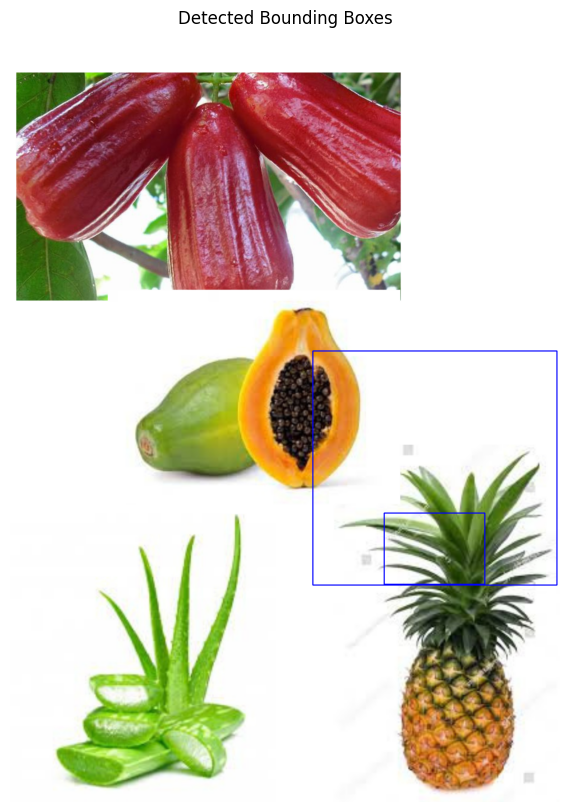

In [31]:
import cv2
import matplotlib.pyplot as plt

# Load the original image
image = cv2.imread("canva 1.png")

# Draw bounding boxes on the image
for box in boxes:
    x_min, y_min, x_max, y_max = map(int, box)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue boxes

# Convert BGR to RGB for visualization
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Detected Bounding Boxes")
plt.show()


In [32]:
import cv2

# Load original composite image
image = cv2.imread("canva 1.png")

# Crop regions using bounding boxes
cropped_regions = []
for box in boxes:
    x_min, y_min, x_max, y_max = map(int, box)
    cropped_region = image[y_min:y_max, x_min:x_max]
    cropped_regions.append(cropped_region)


In [33]:
from torchvision import transforms

# Define preprocessing pipeline for your classifier
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Adjust to match your classifier input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Preprocess each cropped region
processed_regions = [preprocess(region).unsqueeze(0) for region in cropped_regions]  # Add batch dimension


In [34]:
import torch.nn as nn
import torch.nn.functional as F
class ImprovedPlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedPlantClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 14 * 14)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initialize the model
model = ImprovedPlantClassifier(num_classes=30)  # Match the number of classes during training

# Load the saved weights
model.load_state_dict(torch.load("our_classifier.pth"))

# Set the model to evaluation mode
model.eval()


C:\Users\anirv\AppData\Local\Temp\ipykernel_8816\2666873312.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("our_classifier.pth"))


ImprovedPlantClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [36]:
print(model)


ImprovedPlantClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=30, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [37]:
import torch

# Create a dummy input tensor with the same shape as your data
# Example: (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224)

# Forward pass
output = model(dummy_input)

# Check output shape
print("Output shape:", output.shape)


Output shape: torch.Size([1, 30])


Predicted class indices: [0, 7]


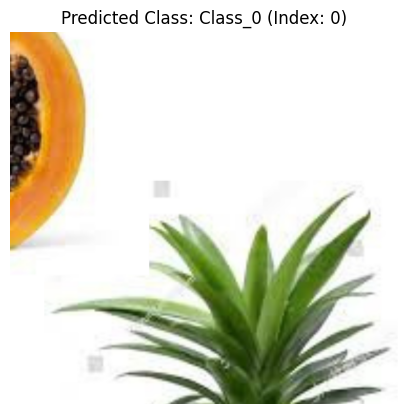

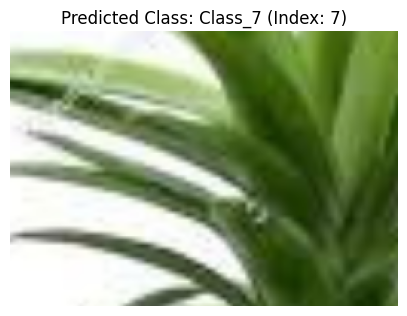

Predicted class for the first input: Class_0 (Index: 0)


In [38]:
import torch
import cv2
import matplotlib.pyplot as plt

# Class names (replace with your actual class labels)
class_names = [f"Class_{i}" for i in range(30)]  # Replace with actual class labels

# Combine processed regions into a single batch tensor
batch_input = torch.stack(processed_regions).squeeze(1)  # Combine and remove extra batch dimension

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    output = model(batch_input)  # Output will have shape [batch_size, num_classes]

# Get the predicted classes
predicted_classes = torch.argmax(output, dim=1).tolist()  # Convert to list of predicted indices
print("Predicted class indices:", predicted_classes)

# Display each cropped region with its predicted class
for idx, (region, class_idx) in enumerate(zip(cropped_regions, predicted_classes)):
    plt.figure(figsize=(5, 5))  # Adjust the figure size if needed
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.title(f"Predicted Class: {class_names[class_idx]} (Index: {class_idx})")
    plt.axis("off")
    plt.show()

# Optional: Get the predicted class for the first input
predicted_class_first = predicted_classes[0]  # First region's predicted class
print(f"Predicted class for the first input: {class_names[predicted_class_first]} (Index: {predicted_class_first})")
